In [2]:
import pickle
import pydicom as dicom 
import matplotlib.pylab as plt
import numpy as np
import os
import pandas as pd
import torch

(3518, 2800)


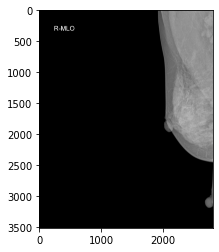

In [10]:
image_path = 'TestFolder/49b30dc89b50238ac3fcc6d5d643d621.dicom'
ds = dicom.dcmread(image_path)
print(ds.pixel_array.shape)
plt.imshow(ds.pixel_array, cmap='gray') #.pixel_array is pixel data

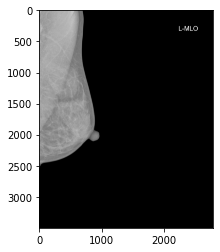

In [91]:
plt.imshow(ds.pixel_array[:3500,:], cmap='gray') #.pixel_array is pixel data

In [8]:
path = '/Users/Benjamin/Desktop/Projects/mammography/preprocessing/TestFolder'
path2 = '/Users/Benjamin/Desktop/Projects/mammography/preprocessing/placement'
# for im in os.listdir(path):
#     pickle.load(open(f'{path}/{im}','rb'))
for im in os.listdir(path):
    if im != '.DS_Store':
        print(im)
        ds = dicom.dcmread(f'{path}/{im}')
        ds.pixel_array 

451562831387e2822923204cf8f0873e.dicom
fcf12c2803ba8dc564bf1287c0c97d9a.dicom


In [85]:
test_set = {}
train_set = {}
laterality_view = {}
left_breast_birad = {}
right_breast_birad = {}

df = pd.read_csv('breast-level_annotations.csv')
for i in range(df.shape[0]): #Go through every row 
    row_data = df.iloc[i] #Specific row
    study_id = row_data['study_id'] #Patient ID
    split = row_data['split'] # Train or test 
    image_id = row_data['image_id'] #Image ID
    
    laterality = row_data['laterality'] #Laterality
    view = row_data['view_position'] #View
    birad = row_data['breast_birads'][-1:] #rating of breast cancer
    
    
    lat_view_tup = (laterality, view) # Tuple to check in later loop
    
    #Dictionary that makes it easy to find axis later in main()
    if lat_view_tup == ('L','CC'):
        laterality_view[image_id] = 0
    elif lat_view_tup == ('L','MLO'):
        laterality_view[image_id] = 1
    elif lat_view_tup == ('R','CC'):
        laterality_view[image_id] = 2
    elif lat_view_tup == ('R','MLO'):
        laterality_view[image_id] = 3
        
    #Dictionaries that find BIRADS for each breast on each patient 
    if laterality == "L":
        if study_id not in left_breast_birad.keys():
            left_breast_birad[study_id] = birad
        else:
            if left_breast_birad[study_id] != birad:
                print('Issue; Left breast BIRADs do not match')
    elif laterality == "R":
        if study_id not in right_breast_birad.keys():
            right_breast_birad[study_id] = birad
        else:
            if right_breast_birad[study_id] != birad:
                print('Issue; right breast BIRADs do not match')
    
    #Splitting image_ids into test or train based on patient 
    if split == 'training':
        if study_id not in train_set.keys():
            train_set[study_id] = [image_id]
        else:
            train_set[study_id].append(image_id)
    
    elif split == 'test':
        if study_id not in test_set.keys():
            test_set[study_id] = [image_id]
        else:
            test_set[study_id].append(image_id)
            
#Dictionary that contains tuple of (left_birad, right_birad)
assert(len(left_breast_birad) == len(right_breast_birad))
left_right_birad = {}
for key in right_breast_birad.keys():
    right_birad = right_breast_birad[key]
    left_birad = left_breast_birad[key]
    left_right_birad[key] = (left_birad,right_birad)

In [26]:
df

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split
0,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,d8125545210c08e1b1793a5af6458ee2,L,CC,3518,2800,BI-RADS 2,DENSITY C,training
1,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,290c658f4e75a3f83ec78a847414297c,L,MLO,3518,2800,BI-RADS 2,DENSITY C,training
2,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,cd0fc7bc53ac632a11643ac4cc91002a,R,CC,3518,2800,BI-RADS 2,DENSITY C,training
3,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,71638b1e853799f227492bfb08a01491,R,MLO,3518,2800,BI-RADS 2,DENSITY C,training
4,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,dd9ce3288c0773e006a294188aadba8e,L,CC,3518,2800,BI-RADS 1,DENSITY C,training
...,...,...,...,...,...,...,...,...,...,...
19995,f2093a752e6b44df5990f5fd38c99dd2,2b1b2b8f48abab9819c0b3d091e152ee,ea732154d149f619b20070b78060ae65,R,CC,2812,2012,BI-RADS 2,DENSITY C,training
19996,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,4689616c3d0b46fcba7a771107730791,R,CC,3580,2702,BI-RADS 2,DENSITY C,training
19997,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,3c22491bcf1d0b004715c28d80981cdd,L,CC,3580,2702,BI-RADS 2,DENSITY C,training
19998,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,d443b9725e331b8b27589aa725597801,R,MLO,3580,2686,BI-RADS 2,DENSITY C,training


In [105]:
df = pd.read_csv('breast-level_annotations.csv')
left_birads = list(df[df['laterality'] == 'L']['breast_birads'])
patients = list(df[df['laterality'] == 'L']['study_id'])
image_ids = list(df[df['laterality'] == 'L']['image_id'])


for i in range(0,len(left_birads)-1,2):
#     print(f'\n{patients[i]}/{image_ids[i]} {left_birads[i]} != \n{patients[i+1]}/{image_ids[i+1]} {left_birads[i+1]}')
    assert (left_birads[i] == left_birads[i+1]), f'\n{patients[i]}/{image_ids[i]} {left_birads[i]} != \n{patients[i+1]}/{image_ids[i+1]} {left_birads[i+1]}'
    assert (patients[i] == patients[i+1])

right_birads = list(df[df['laterality'] == 'R']['breast_birads'])
patients = list(df[df['laterality'] == 'R']['study_id'])
image_ids = list(df[df['laterality'] == 'R']['image_id'])
    

for i in range(0,len(right_birads)-1,2):
#     print(f'\n{patients[i]}/{image_ids[i]} {left_birads[i]} != \n{patients[i+1]}/{image_ids[i+1]} {left_birads[i+1]}')
    assert (right_birads[i] == right_birads[i+1]), f'\n{patients[i]}/{image_ids[i]} {right_birads[i]} != \n{patients[i+1]}/{image_ids[i+1]} {right_birads[i+1]}'
    assert (patients[i] == patients[i+1])
    

In [16]:
df[df['study_id'] == '0025a5dc99fd5c742026f0b2b030d3e9']

# ├── metadata.csv
# ├── breast-level_annotations.csv
# ├── finding_annotations.csv
# └── images
#     ├── 0025a5dc99fd5c742026f0b2b030d3e9
#     │   ├── 2ddfad7286c2b016931ceccd1e2c7bbc.dicom
#     │   ├── 451562831387e2822923204cf8f0873e.dicom
#     │   ├── 47c8858666bcce92bcbd57974b5ce522.dicom
#     │   └── fcf12c2803ba8dc564bf1287c0c97d9a.dicom
#     ├── ...
#     └── fff2339ea4b5d2f1792672ba7d52b318
#         ├── 5144bf29398269fa2cf8c36b9c6db7f3.dicom
#         ├── e4199214f5b40bd40847f5c2aedc44ef.dicom
#         ├── e9b6ffe97a3b4b763cf94c9982254beb.dicom
#         └── f1b6aa1cc6246c2760b882243657212e.dicom

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split
4868,0025a5dc99fd5c742026f0b2b030d3e9,47d59b788d64eecab165d97471c4131a,451562831387e2822923204cf8f0873e,L,CC,3518,2800,BI-RADS 1,DENSITY C,test
4869,0025a5dc99fd5c742026f0b2b030d3e9,47d59b788d64eecab165d97471c4131a,2ddfad7286c2b016931ceccd1e2c7bbc,L,MLO,3518,2800,BI-RADS 1,DENSITY C,test
4870,0025a5dc99fd5c742026f0b2b030d3e9,47d59b788d64eecab165d97471c4131a,fcf12c2803ba8dc564bf1287c0c97d9a,R,CC,3518,2800,BI-RADS 1,DENSITY C,test
4871,0025a5dc99fd5c742026f0b2b030d3e9,47d59b788d64eecab165d97471c4131a,47c8858666bcce92bcbd57974b5ce522,R,MLO,3518,2800,BI-RADS 1,DENSITY C,test


In [9]:
print(len(df['study_id'].unique()))
print(len(df['series_id'].unique()))

5000
5036


In [11]:
print(df['breast_birads'].value_counts())
print(df['breast_density'].value_counts())

BI-RADS 1    13406
BI-RADS 2     4676
BI-RADS 3      930
BI-RADS 4      762
BI-RADS 5      226
Name: breast_birads, dtype: int64
DENSITY C    15292
DENSITY D     2700
DENSITY B     1908
DENSITY A      100
Name: breast_density, dtype: int64


In [159]:
df = pd.read_csv('breast-level_annotations.csv')
df.head(12)

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split
0,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,d8125545210c08e1b1793a5af6458ee2,L,CC,3518,2800,BI-RADS 2,DENSITY C,training
1,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,290c658f4e75a3f83ec78a847414297c,L,MLO,3518,2800,BI-RADS 2,DENSITY C,training
2,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,cd0fc7bc53ac632a11643ac4cc91002a,R,CC,3518,2800,BI-RADS 2,DENSITY C,training
3,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,71638b1e853799f227492bfb08a01491,R,MLO,3518,2800,BI-RADS 2,DENSITY C,training
4,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,dd9ce3288c0773e006a294188aadba8e,L,CC,3518,2800,BI-RADS 1,DENSITY C,training
5,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,57fbdd278af5c8789a02b355c11620d4,L,MLO,3518,2800,BI-RADS 1,DENSITY C,training
6,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,202d761a6b0f86faaeefc39ee18b1c53,R,CC,3518,2800,BI-RADS 1,DENSITY C,training
7,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,acccc1727b61b261844d86aa9de53536,R,MLO,3518,2800,BI-RADS 1,DENSITY C,training
8,fa4dcd0f3ba24e86fc8dc25091f7ebd5,a78f4822d806b4f69ba9f0e0c68778b4,a3d0e2394d7db36afab1b6e5e24da798,L,CC,3518,2800,BI-RADS 1,DENSITY C,training
9,fa4dcd0f3ba24e86fc8dc25091f7ebd5,a78f4822d806b4f69ba9f0e0c68778b4,48b243704d16570155df12995a284b61,L,MLO,3518,2800,BI-RADS 1,DENSITY C,training


In [101]:

# df = pd.read_csv('breast-level_annotations.csv')
# print(df['height'].value_counts())
# print(df['width'].value_counts())

# {'patient': {'L': score, 'R': score} }

# df = pd.read_csv('breast-level_annotations.csv')
# df
# # df[(df['height'] == '3518') & (df['width'] == '2800')]

In [163]:
df = pd.read_csv('breast-level_annotations.csv')
df = df[(df['height'] == 3518) & (df['width'] == 2800)]
df = df[~df['study_id'].isin(['dbca9d28baa3207b3187c4d07dc81a80'])]


patients = list(df['study_id'].unique())
image_ids = list(df['image_id'])

left_breast_birads = df[((df['laterality'] == 'L') & (df['view_position'] == 'CC')) ]['breast_birads']
right_breast_birads = df[((df['laterality'] == 'R') & (df['view_position'] == 'CC')) ]['breast_birads']


print(len(df[((df['laterality'] == 'L') & (df['view_position'] == 'MLO'))] ))
print(len(df[((df['laterality'] == 'L') & (df['view_position'] == 'CC'))] ))


print(len(df[((df['laterality'] == 'R') & (df['view_position'] == 'MLO'))] ))
print(len(df[((df['laterality'] == 'R') & (df['view_position'] == 'CC'))]))

left_breast_birads = list(left_breast_birads.map(lambda x : int(x[-1])))
right_breast_birads = list(right_breast_birads.map(lambda x : int(x[-1])))

label_dict = dict()

# assert(len(breast_birads) == 2* len(patients)), f'{len(breast_birads)} {len(patients)}'
i = 0
for patient in patients:
    left_label = left_breast_birads[i]
    right_label = right_breast_birads[i]
    label_dict[patient] = {'L': left_label , 'R': right_label }
    i += 1
    
label_dict


# res = [f'{p}/{i}' for p, i in zip(patients, image_ids)]
# res

3810
3810
3810
3810


{'b8d273e8601f348d3664778dae0e7e0b': {'L': 2, 'R': 2},
 '8269f5971eaca3e5d3772d1796e6bd7a': {'L': 1, 'R': 1},
 'fa4dcd0f3ba24e86fc8dc25091f7ebd5': {'L': 1, 'R': 1},
 '0a0c5108270e814818c1ad002482ce74': {'L': 1, 'R': 1},
 'ac4975eb788af8b7e15cafca9ac9a1c9': {'L': 1, 'R': 1},
 '87f322198db11b86e20ad96ea29eb010': {'L': 1, 'R': 1},
 'cca141f804a8ab8b584d63102bc7f3f7': {'L': 3, 'R': 1},
 '9ec3039bf215173edf48a8b4f23ad56a': {'L': 4, 'R': 1},
 '2c314c0a8f364d1a8889bb555d3d04c9': {'L': 1, 'R': 2},
 '7ee98232df9bcefc6b54530b6a616690': {'L': 3, 'R': 2},
 '522963c771a84cb777c49ba7a4ca69fc': {'L': 1, 'R': 2},
 'b738a510998dc553563c344b2e3e684c': {'L': 1, 'R': 1},
 '229b0c72152c8c7c6cd902876046c795': {'L': 1, 'R': 1},
 'cfe8618e153122b7b95296bb1b991b90': {'L': 1, 'R': 1},
 '6103811434cbc0a8478c71b4a955ed57': {'L': 1, 'R': 1},
 '1734a10c08f2565315493df00a2fd134': {'L': 4, 'R': 2},
 '10200894bf6f74b2ae92a0cecd37c60c': {'L': 1, 'R': 5},
 '17659a68a1d991d89fbf041a70b93d5f': {'L': 2, 'R': 1},
 '0ba0f88b

In [173]:


for patient in patients:
    curr_df = df[df['study_id'] == patient]
    lmlo_image_id = list(curr_df[((curr_df['laterality'] == 'L') & (curr_df['view_position'] == 'MLO')) ]['image_id'])[0]
    lcc_image_id = list(curr_df[((curr_df['laterality'] == 'L') & (curr_df['view_position'] == 'CC')) ]['image_id'])[0]
    rmlo_image_id = list(curr_df[((curr_df['laterality'] == 'R') & (curr_df['view_position'] == 'MLO')) ]['image_id'])[0]
    rcc_image_id = list(curr_df[((curr_df['laterality'] == 'R') & (curr_df['view_position'] == 'CC')) ]['image_id'])[0]
#     print(lmlo_image_id)
#     print(lcc_image_id)
#     print(rmlo_image_id)
#     print(rcc_image_id)
#     break

In [162]:

df = pd.read_csv('breast-level_annotations.csv')
df["type"] = df["laterality"].astype(str) + df["view_position"].astype(str)


table = pd.pivot_table(df, index=['study_id','image_id','type'])
table.head(13)


#                          units
# store_nbr   item_nbr    
#    1            9        27396
#                 28        4893
#                 40        254
#                 47        2409
#                 51        925
#                 89        157
#                 93        1103
#                 99        492

#     2           5         55104
#                 11        655
#                 44        117125
#                 85        106
#                 93        653

table = table.reset_index()
table.head(16)
# d = {k: v.tolist() for k, v in table.groupby("study_id")["type"]}


# for k in d:
    
#     if len(set(d[k])) != 4:
#         print(k)

# df[df['study_id'] == 'dbca9d28baa3207b3187c4d07dc81a80']

# c = ['study_id','series_id','image_id','laterality','view_position','height','width','breast_birads','breast_density','split']

/var/folders/t7/pdp6dd5561d8pg9l84h6tbmm0000gn/T/ipykernel_8339/3440580669.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  table = pd.pivot_table(df, index=['study_id','image_id','type'])


,study_id,image_id,type,height,width
0,0025a5dc99fd5c742026f0b2b030d3e9,2ddfad7286c2b016931ceccd1e2c7bbc,LMLO,3518,2800
1,0025a5dc99fd5c742026f0b2b030d3e9,451562831387e2822923204cf8f0873e,LCC,3518,2800
2,0025a5dc99fd5c742026f0b2b030d3e9,47c8858666bcce92bcbd57974b5ce522,RMLO,3518,2800
3,0025a5dc99fd5c742026f0b2b030d3e9,fcf12c2803ba8dc564bf1287c0c97d9a,RCC,3518,2800
4,0028fb2c7f0b3a5cb9a80cb0e1cdbb91,16e58fc1d65fa7587247e6224ee96527,RMLO,3518,2800
5,0028fb2c7f0b3a5cb9a80cb0e1cdbb91,3704f91985dcbc69f6ac2803523d1ecb,LCC,3518,2800
6,0028fb2c7f0b3a5cb9a80cb0e1cdbb91,7fc1f1bb8bb1a7efaf7104e49c4d8b86,LMLO,3518,2800
7,0028fb2c7f0b3a5cb9a80cb0e1cdbb91,c4ce68631bf70949570ded31a3c69e60,RCC,3518,2800
8,0034765af074f93ed33d5e8399355caf,2aca993b3b6e2a32dddd170b00fd5e7d,RCC,3518,2800
9,0034765af074f93ed33d5e8399355caf,68f09c18925a66ef2840d4a62f237b31,LCC,3518,2800


In [144]:
# df2 = df[((df['laterality'] == 'L') & (df['view_position'] == 'MLO'))]
# df2  


In [145]:
# df3 = df[((df['laterality'] == 'L') & (df['view_position'] == 'CC'))]
# df3 

In [146]:
# df[((df['laterality'] == 'R') & (df['view_position'] == 'MLO'))]


In [147]:
# df[((df['laterality'] == 'R') & (df['view_position'] == 'CC'))]

In [93]:
def main():
    path1 = '' #need to input correct path name that refers to all patient
    path2 = '' #Where to save data (needs to have test and train folders)
    
    for patient in os.listdir(path): #going into each patient folder
        patient_tensor = torch.zeros(4,3518,2800) #Tensor that has all 4 scans of patient that are (3518,2800)
        i = 0
        for scan in os.listdir(f'{path}/{patient}'): #Going into each scan
            ds = dicom.dcmread(f'{path}/{patient}/{scan}') #Reading scan via dicom (can't figure out open)
            correct_type_array = np.ascontiguousarray(ds.pixel_array[:3500,:],dtype = np.float32)
            scan_array = torch.from_numpy(correct_type_array) #making array (3500,2800) good numbers
            axis = laterality_view[scan] #Checking dictionary to see what laterality and view it is
            patient_tensor[axis,:,:] = scan_array #Putting it in correct dimension 
            i += 1
        assert(i == 4) #Checking all four scans were done
        
        patient_readings = left_right_birad[patient]
        patient_list = (patient_tensor, patient_readings) # tuple of (tensor, (left birad, right birad))
        
        #Saving to correct data subfolder
        if patient in training.keys():
            pickle.dump(patient_list, open(f'{path}/train/{patient}.pt', "wb"))
        else:
            pickle.dump(patient_list, open(f'{path}/test/{patient}.pt', "wb"))
            
#At the end of preprocessing, path2/ should have two folders: test and train, each of which have 
#hundreds of .pt files that each are a tuple of array (4,3518,2800) and tuple (left, right)
#
#The goal of training and testing should be for looping through each of these .pt files, training on array and compare
#to tuple 